PPO Car Racing Model with original environment

In [ ]:
!pip install gym[box2d]
!apt-get install -y xvfb x11-utils
!pip install pyvirtualdisplay==0.2.*
!pip install stable-baselines3[extra]

Reading package lists... Done
Building dependency tree       
Reading state information... Done
x11-utils is already the newest version (7.7+3build1).
xvfb is already the newest version (2:1.19.6-1ubuntu4.10).
The following package was automatically installed and is no longer required:
  libnvidia-common-470
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

import gym
from gym.wrappers.monitoring.video_recorder import VideoRecorder

from IPython.display import HTML
from pyvirtualdisplay import Display
from base64 import b64encode
from stable_baselines3 import SAC, PPO

from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import BaseCallback

class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """
    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

          # Retrieve training reward
          x, y = ts2xy(load_results(self.log_dir), 'timesteps')
          if len(x) > 0:
              # Mean training reward over the last 100 episodes
              mean_reward = np.mean(y[-100:])
              if self.verbose > 0:
                print(f"Num timesteps: {self.num_timesteps}")
                print(f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}")

              # New best model, you could save the agent here
              if mean_reward > self.best_mean_reward:
                  self.best_mean_reward = mean_reward
                  # Example for saving best model
                  if self.verbose > 0:
                    print(f"Saving new best model to {self.save_path}.zip")
                  self.model.save(self.save_path)

        return True

In [ ]:
# Create log dir
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

#env = make_vec_env("CarRacing-v0")
env = gym.make("CarRacing-v0")
env = Monitor(env, log_dir)

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [ ]:
#Number of timesteps to train the model in
training_timesteps = 30_000

# Separate evaluation env
eval_env = make_vec_env('CarRacing-v0')
# Use deterministic actions for evaluation
eval_callback = EvalCallback(eval_env, best_model_save_path='./logs/',
                             log_path='./logs/', eval_freq=500,
                             deterministic=True, render=False)

display = Display(visible=False, size=(1400, 900))
_ = display.start()

after_training = "after_training.mp4"
#model = SAC("CnnPolicy", env, verbose=1, learning_rate=0.0003, buffer_size = 500)
model = PPO("CnnPolicy", env, learning_rate=0.0003, n_steps=1024, batch_size=64, n_epochs=10, gamma=0.99, gae_lambda=0.95, clip_range=0.2, seed=8)
video = VideoRecorder(env, after_training)
print(env.action_space)

callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)
model.learn(total_timesteps=training_timesteps, callback=callback)

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Box(-1.0, 1.0, (3,), float32)
Track generation: 1164..1459 -> 295-tiles track
Track generation: 1211..1518 -> 307-tiles track
Num timesteps: 1000
Best mean reward: -inf - Last mean reward per episode: -59.18
Saving new best model to /tmp/gym/best_model.zip
Track generation: 850..1069 -> 219-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1060..1329 -> 269-tiles track
Num timesteps: 2000
Best mean reward: -59.18 - Last mean reward per episode: -53.45
Saving new best model to /tmp/gym/best_model.zip
Track generation: 1223..1538 -> 315-tiles track
Num timesteps: 3000
Best mean reward: -53.45 - Last mean reward per episode: -50.31
Saving new best model to /tmp/gym/best_model.zip
Track generation: 1380..1729 -> 349-tiles track
Num timesteps: 4000
Best mean reward: -50.31 - Last mean reward per episode: -49.99
Saving new best model to /tmp/gym/best_model.zip
Track generation: 1201..1505 -> 304-tiles track
Num timesteps: 5000
Best 

In [ ]:
#Validation
obs = env.reset()
for i in range(3000):
  action, _states = model.predict(obs.copy(), deterministic=True)
  video.capture_frame()
  # env.action_space.sample() produces either 0 (left) or 1 (right).
  obs, reward, done, info = env.step(action)
  env.render()
  #print("step", i, observation, reward, done, info)
  if done:
    obs = env.reset()
    break

video.close()
env.close()

Track generation: 1083..1358 -> 275-tiles track
Track generation: 1221..1530 -> 309-tiles track


In [ ]:
def render_mp4(videopath: str) -> str:
  
  mp4 = open(videopath, 'rb').read()
  base64_encoded_mp4 = b64encode(mp4).decode()
  return f'<video width=400 controls><source src="data:video/mp4;' \
         f'base64,{base64_encoded_mp4}" type="video/mp4"></video>'

from IPython.display import HTML
html = render_mp4(after_training)
HTML(html)

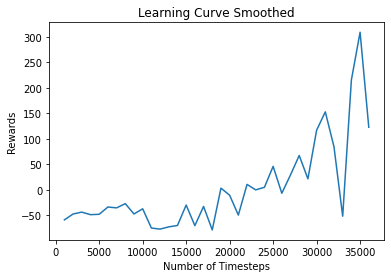

In [ ]:


def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')


def plot_results(log_folder, title='Learning Curve'):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), 'timesteps')
    #y = moving_average(y, window=50)
    # Truncate x
    x = x[len(x) - len(y):]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel('Number of Timesteps')
    plt.ylabel('Rewards')
    plt.title(title + " Smoothed")
    plt.show()

plot_results(log_dir)